# Classification of 3D shapes

In [5]:
import time
start = time.time()


# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module
import os
import open3d as o3d

# Data viz
from gtda.plotting import plot_point_cloud
from gtda.plotting import plot_diagram

# TDA magic
from gtda.homology import VietorisRipsPersistence
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

end = time.time()
print("Time to load libraries:", end - start, "s")

Time to load libraries: 0.0 s


## Import data

Downloaded from McGill 3D Shape Benchmark: http://www.cim.mcgill.ca/~shape/benchMark/index.html.

In [9]:
def get_ply_files(folder):
    files = list(filter(lambda file: file.split('.')[-1]=='ply', os.listdir(folder)))
    files = list(map(lambda file: os.path.join(folder, file),files))
    return files

ply_files  = get_ply_files('data/tablesPly')
ply_files += get_ply_files('data/chairsPly')
ply_files += get_ply_files('data/octopusesPly')
ply_files += get_ply_files('data/spidersPly')

labels, index = np.zeros(len(ply_files)), len(os.listdir('data/tablesPly')), 
index2 = index + len(os.listdir('data/chairsPly'))
labels[index:index2] = 1
index, index2 = index2, index2 + len(os.listdir('data/octopusesPly'))
labels[index:index2] = 2
labels[index2:] = 3

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/tablesPly'

In [7]:
# tables 0-21, chairs 22-44, cups 45-69, humans 70-98
pcd = [o3d.io.read_point_cloud(file) for file in ply_files]
pcd = [np.asarray(pc.points) for pc in pcd]
# print(pcd.shape, labels.shape)

NameError: name 'ply_files' is not defined

In [8]:
plot_point_cloud(pcd[50])

NameError: name 'pcd' is not defined

## Simplify data and construct network

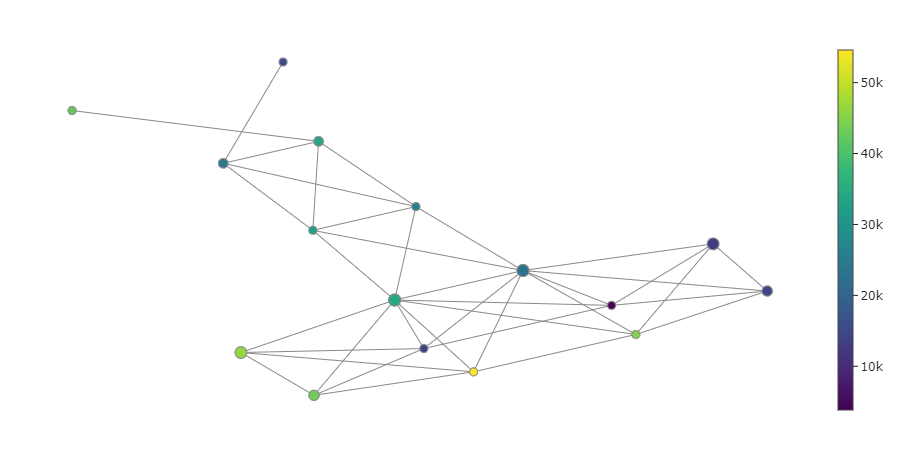

In [ ]:
#filter_func = Projection(columns=[0,1,2])
filter_func = PCA(n_components=2)

cover = CubicalCover(n_intervals=4, overlap_frac=0.08)
#cover = OneDimensionalCover(kind='uniform', n_intervals=10, overlap_frac=0.1)

clusterer = DBSCAN(eps=10, metric="chebyshev")

n_jobs = 1

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

fig = plot_static_mapper_graph(pipe, pcd[50])
fig.show(config={'scrollZoom': True})

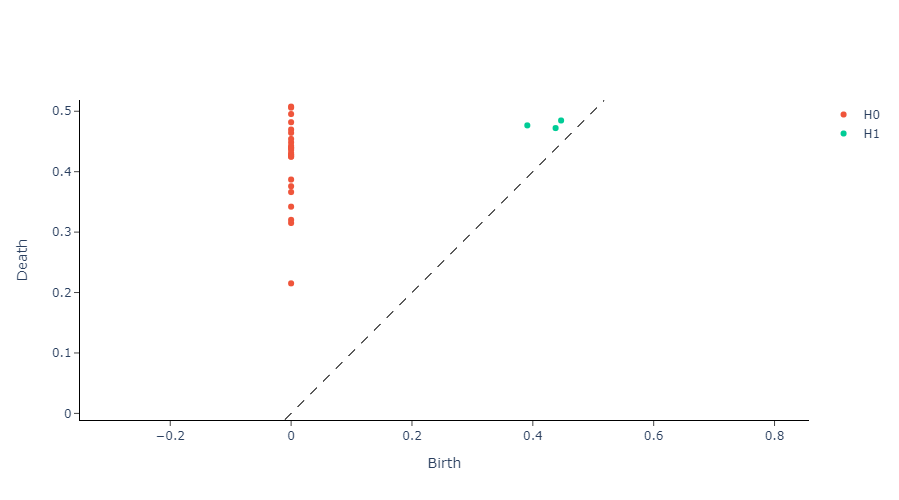

In [ ]:
mapped_points = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
diagram_chair = persistence.fit_transform(mapped_points[None, :, :])
plot_diagram(diagram_chair[0])

In [ ]:
start = time.time()
graphs = [pipe.fit_transform(pc) for pc in pcd]
end = time.time()
print("Time to compute create smaller graphs with mapper:", end - start, "s")

Time to compute create smaller graphs with mapper: 120.23631310462952 s


In [ ]:
graphs[0]

In [ ]:
start = time.time()
figures = [plot_static_mapper_graph(pipe, pc) for pc in pcd]
end = time.time()
print("Time to compute create smaller graphs with mapper:", end - start, "s")

figures[0].show(config={'scrollZoom': True})

## Network analysis

 

In [ ]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

In [ ]:
results = []
for fig in figures:
    mapped_points = np.array(list(x for x in zip(fig.data[1].x, fig.data[1].y) if None not in x))
    diagram = persistence.fit_transform(mapped_points[None, :, :])
    results.append(diagram[0])

## Object classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from gtda.diagrams import Amplitude, PersistenceEntropy

entropy_results = np.array([PersistenceEntropy().fit_transform(r[None,:,:])[0] for r in results])
amplitude_w_results = np.array([Amplitude(metric='wasserstein').fit_transform(r[None, :, :])[0] for r in results])
amplitude_b_results = np.array([Amplitude(metric='bottleneck').fit_transform(r[None, :, :])[0] for r in results])

rf_ent = RandomForestClassifier(oob_score=True, random_state=42)
rf_ent.fit(entropy_results, labels)
print(f"Entropy OOB score: {rf_ent.oob_score_:.3f}")

rf_amp = RandomForestClassifier(oob_score=True, random_state=42)
rf_amp.fit(amplitude_w_results, labels)
print(f"Amplitude OOB score: {rf_amp.oob_score_:.3f} using wasserstein distance")

rf_bot = RandomForestClassifier(oob_score=True, random_state=42)
rf_bot.fit(amplitude_b_results, labels)
print(f"Amplitude OOB score: {rf_bot.oob_score_:.3f} using bottleneck distance")

# plot_point_cloud([p for p in zip(entropy_results, amplitude_w_results, amplitude_b_results)], color = labels)

Entropy OOB score: 0.747
Amplitude OOB score: 0.717 using wasserstein distance
Amplitude OOB score: 0.768 using bottleneck distance


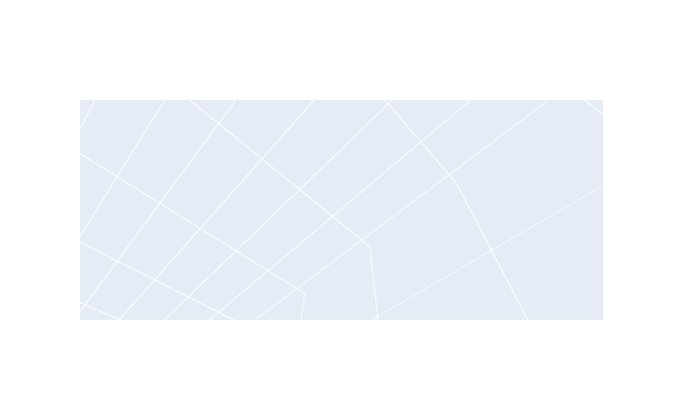

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        mode='markers',
        x=entropy_results[:,0],
        y=entropy_results[:,1],
        z=entropy_results[:,2],
        marker=dict(
            size=5,
            color = labels
        )
    )
)
fig.update_layout(height=400, width=400)
fig.show()

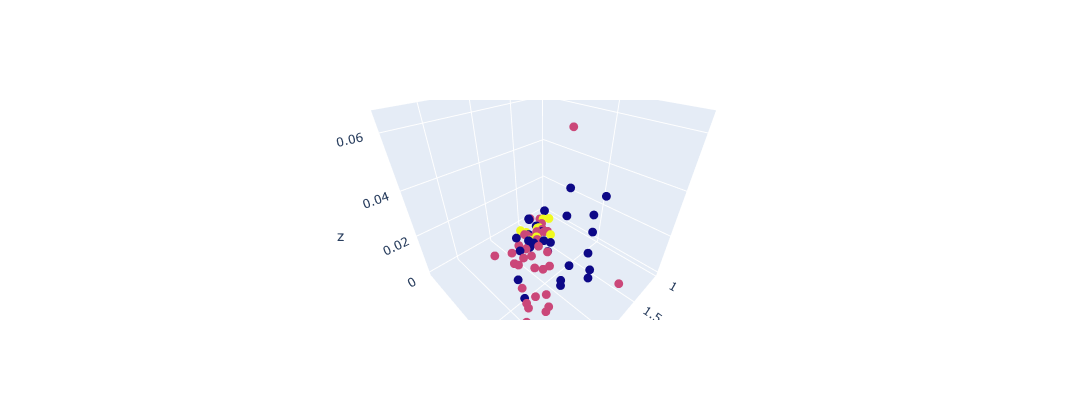

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        mode='markers',
        x=amplitude_w_results[:,0],
        y=amplitude_w_results[:,1],
        z=amplitude_w_results[:,2],
        marker=dict(
            size=5,
            color = labels
        )
    )
)
fig.update_layout(height=400, width=400)
fig.show()

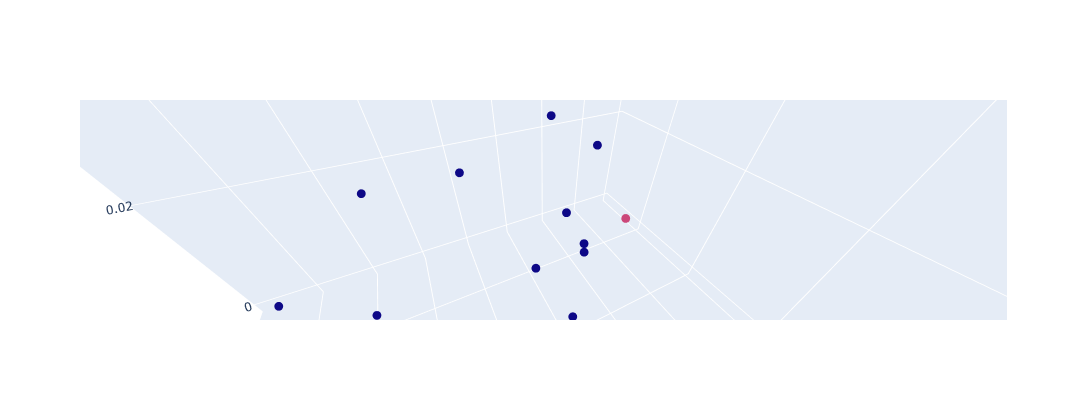

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter3d(
        mode='markers',
        x=amplitude_b_results[:,0],
        y=amplitude_b_results[:,1],
        z=amplitude_b_results[:,2],
        marker=dict(
            size=5,
            color = labels
        )
    )
)
fig.update_layout(height=400, width=400)
fig.show()

In [ ]:
# distance = PairwiseDistance()
# distance_matrix = distance.fit(results)

In [ ]:
from gudhi import bottleneck_distance

pairwise_distances = [
    [bottleneck_distance([(y, z) for (x, y, z) in diag1[None,:,:][0]], [(y, z) for (x, y, z) in diag2[None,:,:][0]])
    for diag1 in results] for diag2 in results
]

In [ ]:
from gtda import plotting.plot_heatmap
plot_heatmap()

In [ ]:
from gtda.diagrams import PairwiseDistance

distance = PairwiseDistance()
distance_matrix = distance.fit(diagrams)